# Deep Deterministic Policy Gradient (DDPG)

## Introduction

**Deep Deterministic Policy Gradient (DDPG)** is a model-free off-policy algorithm for
learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network).
It uses Experience Replay and slow-learning target networks from DQN, and it is based on
DPG,
which can operate over continuous action spaces.

This tutorial closely follow this paper -
[Continuous control with deep reinforcement learning](https://arxiv.org/pdf/1509.02971.pdf)

## Problem

We are trying to solve the classic **Inverted Pendulum** control problem.
In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions
are **continuous** instead of being **discrete**. That is, instead of using two
discrete actions like `-1` or `+1`, we have to select from infinite actions
ranging from `-2` to `+2`.

## Quick theory

Just like the Actor-Critic method, we have two networks:

1. Actor - It proposes an action given a state.
2. Critic - It predicts if the action is good (positive value) or bad (negative value)
given a state and an action.

DDPG uses two more techniques not present in the original DQN:

**First, it uses two Target networks.**

**Why?** Because it add stability to training. In short, we are learning from estimated
targets and Target networks are updated slowly, hence keeping our estimated targets
stable.

Conceptually, this is like saying, "I have an idea of how to play this well,
I'm going to try it out for a bit until I find something better",
as opposed to saying "I'm going to re-learn how to play this entire game after every
move".
See this [StackOverflow answer](https://stackoverflow.com/a/54238556/13475679).

**Second, it uses Experience Replay.**

We store list of tuples `(state, action, reward, next_state)`, and instead of
learning only from recent experience, we learn from sampling all of our experience
accumulated so far.

Now, let's see how is it implemented.

In [ ]:
# So it'll reload the enviorment as I make changes to it
%load_ext autoreload
%autoreload 2

In [262]:
# Imports
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import matplotlib.pyplot as plt
from cartpole import CartPoleEnv
import random
from Cope.plotly import ridgeplot
import polars as pl

We use [OpenAIGym](http://gym.openai.com/docs) to create the environment.
We will use the `upper_bound` parameter to scale our actions later.

In [263]:
# Enviorment setup
# Initial: force=3, fps=None, start_angle_range=.05, bounds_size=2.4
# Stable:  force=3, fps=20,   start_angle_range=.05, bounds_size=2.4
env = CartPoleEnv(force=3, fps=20, start_angle_range=.05, bounds_size=2.4)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(f"Size of State Space: {num_states}")
print(f"Size of Action Space: {num_actions}")
print(f"Max Value of Action: {upper_bound}")
print(f"Min Value of Action: {lower_bound}")

Size of State Space: 2
Size of Action Space: 1
Max Value of Action: 1.0
Min Value of Action: -1.0


The `Buffer` class implements Experience Replay.

---
![Algorithm](https://i.imgur.com/mS6iGyJ.jpg)
---


**Critic loss** - Mean Squared Error of `y - Q(s, a)`
where `y` is the expected return as seen by the Target network,
and `Q(s, a)` is action value predicted by the Critic network. `y` is a moving target
that the critic model tries to achieve; we make this target
stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network
for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get
the maximum predicted value as seen by the Critic, for a given state.

In [264]:
class Buffer:
    """ Don't touch this """
    def __init__(self, buffer_capacity=100_000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow
    # operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        return actor_loss, critic_loss

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        return self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


Here we define the Actor and Critic networks. These are basic Dense models
with `ReLU` activation.

Note: We need the initialization for last layer of the Actor to be between
`-0.003` and `0.003` as this prevents us from getting `1` or `-1` output values in
the initial stages, which would squash our gradients to zero,
as we use the `tanh` activation.

In [265]:
# Actor & Critic
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


`policy()` returns an action sampled from our Actor network plus some noise for
exploration.

In [266]:
def policy(state, noise_func):
    sampled_actions = tf.squeeze(actor_model(state))

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise_func()

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## Training hyperparameters

In [267]:
# Config
# Running this cell resets the weights
# Initial: .2 | stable: .2
noise = lambda mu=0, std_dev=0.2: random.gauss(mu, std_dev)

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# If we're resetting weights, reset the episode count
env.reset_count = 0

# Learning rate for actor-critic models
# Initial: .002 | stable: .003
critic_lr = 0.003
# Initial: .001 | stable: .002
actor_lr = 0.002

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# This doesn't matter, it's just how long we're training it for
total_episodes = 250

# Discount factor for future rewards
# Initial: .99 | stable: .99
gamma = 0.99

# Used to update target networks
# Initial: .005 | stable: .005
tau = 0.005

# Initial: 40 | stable: 40
avg_reward_episodes = 40

# Initial: 5000, 64 | stable: 5000, 32
buffer = Buffer(5000, 64)


In [268]:
# Show our configuration in the window
env.show_strings = [
    'Config:',
    f'force: {env.force_mag}',
    f'gamma: {gamma}',
    f'tau: {tau}',
    f'buffer cap: {buffer.buffer_capacity}',
    f'buffer train size: {buffer.batch_size}',
    f'avg of prev: {avg_reward_episodes}',
    f'start angle range: {env.start_angle_range}',
    f'bounds: {env.x_threshold}',
    '-------------------------'
]

In [269]:
# Load the weights, if we have them and we want to
if True:
    actor_model.load_weights("pendulum_actor.h5")
    critic_model.load_weights("pendulum_critic.h5")

    target_actor.load_weights("pendulum_target_actor.h5")
    target_critic.load_weights("pendulum_target_critic.h5")

Now we implement our main training loop, and iterate over episodes.
We sample actions using `policy()` and train with `learn()` at each time step,
along with updating the Target networks at a rate `tau`.

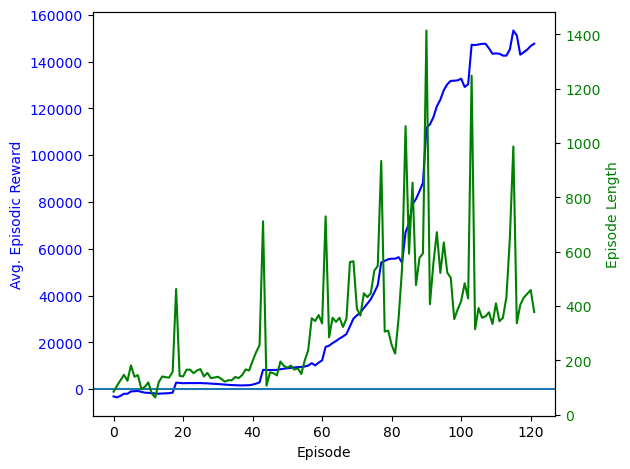

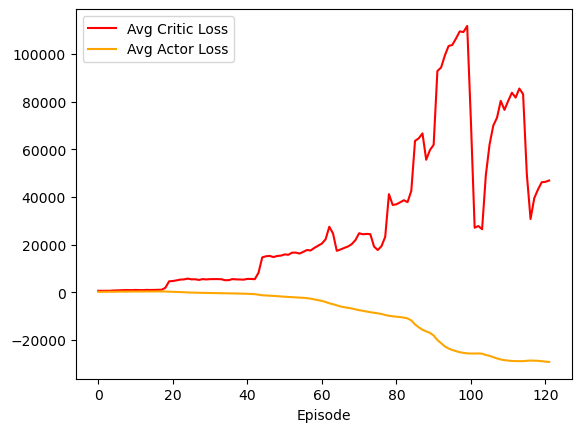

SystemExit: 0

In [271]:
# Running the actual loop

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# These aren't used in the algorithm, they're just so I can make graphs to see what is going on
# To store the length of of each episode
ep_len_list = []
ep_critic_loss = []
ep_actor_loss = []

try:
    for ep in range(total_episodes):
        prev_state, info = env.reset()
        episodic_reward = 0
        step_count = 0
        sum_actor_loss = 0
        sum_critic_loss = 0

        while True:
            step_count += 1
            env.render()

            # Decide what action to take
            action = policy(tf.expand_dims(tf.convert_to_tensor(prev_state), 0), noise)

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)

            buffer.record((prev_state, action, reward, state))
            actor_loss, critic_loss = buffer.learn()

            episodic_reward += reward
            sum_actor_loss += actor_loss
            sum_critic_loss += critic_loss

            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            theta, theta_vel = state
            x, x_vel = info
            # With SimpleGym you can print from wherever, but you have to add an arbitrary key
            env.print['reward'] = f'Reward: {reward:.0f}'
            env.print['a'] = f'Theta: {theta:.2f}'
            # env.print['b'] = f'Angular Velocity: {theta_vel:.2f}'
            # env.print['c'] = f'x: {x:.2f}'
            # env.print['d'] = f'velocity: {x_vel:.2f}'

            # End this episode when `done` is True
            if done: break

            prev_state = state

        ep_reward_list.append(episodic_reward)
        ep_len_list.append(step_count)
        ep_actor_loss.append(sum_actor_loss / step_count)
        ep_critic_loss.append(sum_critic_loss / step_count)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-avg_reward_episodes:])
        avg_reward_list.append(avg_reward)

        env.print['e'] = f'Episode {env.reset_count}/{total_episodes}'
        env.print['f'] = f'Last Episode Len: {step_count}'
        env.print['g'] = f'Avg Reward of the last episode: {episodic_reward/step_count:.1f}'
        env.print['h'] = f'Avg Reward of the last {avg_reward_episodes} episodes: {avg_reward:.1f}'
        # print(f"Episode {ep}: Avg Reward = {avg_reward:.2f}, Length = {step_count}", end='\r')

# Make sure the window closes and we show graphs if we finish or if there's an error
finally:
    # Episodes versus Avg. Rewards and episode lengths
    # plt.plot(avg_reward_list, label='Avg. Reward')
    # plt.plot(np.array(ep_len_list)*5, label='Episode Length', ylim=)
    # plt.xlabel("Episode")
    # plt.ylabel("Avg. Episodic Reward")
    # plt.legend()
    # plt.show()

    fig, ax1 = plt.subplots()

    ax1.plot(avg_reward_list, label='Avg. Reward', color='blue')
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Avg. Episodic Reward", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(y=0, linestyle='-')

    ax2 = ax1.twinx()
    ax2.plot(ep_len_list, label='Episode Length', color='green')
    ax2.set_ylabel("Episode Length", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots()

    # Losses
    plt.plot(ep_critic_loss, label='Avg Critic Loss', color='red')
    plt.plot(ep_actor_loss, label='Avg Actor Loss', color='orange')
    plt.xlabel("Episode")
    plt.legend()
    plt.show()

    env.close()

In [276]:
# Just another visualization of the data
data = pl.DataFrame({
    'Avg. Reward': avg_reward_list,
    'Episode Length': ep_len_list,
    'Avg Actor Loss': ep_actor_loss,
    'Avg Critic Loss': ep_critic_loss,
})
# Add an index column
data = data.with_columns(Episode=pl.int_range(0, len(avg_reward_list)))
ridgeplot(data, x='Episode', z=['Avg. Reward', 'Episode Length', 'Avg Actor Loss', 'Avg Critic Loss'])


In [ ]:
# I made this the other day and want to show it off
from Cope.meme import look_at_this_graph
look_at_this_graph(fig)

If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, `tau` values, and architectures for the
Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other
problems.

Another great environment to try this on is `LunarLandingContinuous-v2`, but it will take
more episodes to obtain good results.

In [274]:
# Save the weights
if False:
    actor_model.save_weights("pendulum_actor.h5")
    critic_model.save_weights("pendulum_critic.h5")

    target_actor.save_weights("pendulum_target_actor.h5")
    target_critic.save_weights("pendulum_target_critic.h5")